In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Transaction 

In [2]:
df = pd.read_csv(r"C:\Users\Wentao\Desktop\EA_recherche\Hawkes\sanofi_hawkes_sell_times.csv")
dg = pd.read_csv(r"C:\Users\Wentao\Desktop\EA_recherche\Hawkes\sanofi_hawkes_buy_times.csv")
print(df.head())

                   trade_time_paris  t_seconds  t_seconds_jitter  MiFIDPrice  \
0  2019-10-01 09:00:18.697716+02:00   0.508150          0.508150       85.30   
1  2019-10-01 09:00:18.754287+02:00   0.564721          0.564721       85.30   
2  2019-10-01 09:00:18.824521+02:00   0.634955          0.634955       85.30   
3  2019-10-01 09:00:19.973249+02:00   1.783683          1.783683       85.33   
4  2019-10-01 09:00:19.973330+02:00   1.783764          1.783764       85.33   

   MiFIDQuantity Venue  
0           75.0  XPAR  
1           56.0  XPAR  
2          179.0  XPAR  
3          110.0  XPAR  
4          140.0  XPAR  


In [3]:
df["trade_time_paris"] = pd.to_datetime(df["trade_time_paris"])
df = df.set_index("trade_time_paris")
dg["trade_time_paris"] = pd.to_datetime(dg["trade_time_paris"])
dg = dg.set_index("trade_time_paris")

In [4]:
# Aggregate by 1 minute and count trades
df_1min = df.resample('1min').size().to_frame('trade_count')
print(df_1min.head())
dg_1min = dg.resample('1min').size().to_frame('trade_count')

                           trade_count
trade_time_paris                      
2019-10-01 09:00:00+02:00           56
2019-10-01 09:01:00+02:00           23
2019-10-01 09:02:00+02:00            7
2019-10-01 09:03:00+02:00           28
2019-10-01 09:04:00+02:00           11


Text(0, 0.5, 'Number of Trades')

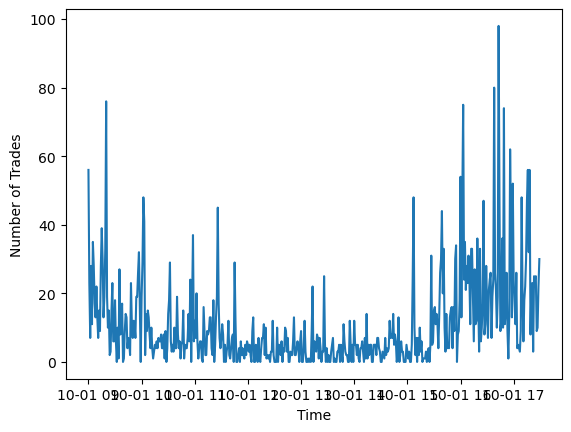

In [5]:
plt.plot(df_1min.index, df_1min['trade_count'])
plt.xlabel('Time')
plt.ylabel('Number of Trades')

Text(0, 0.5, 'Number of Trades')

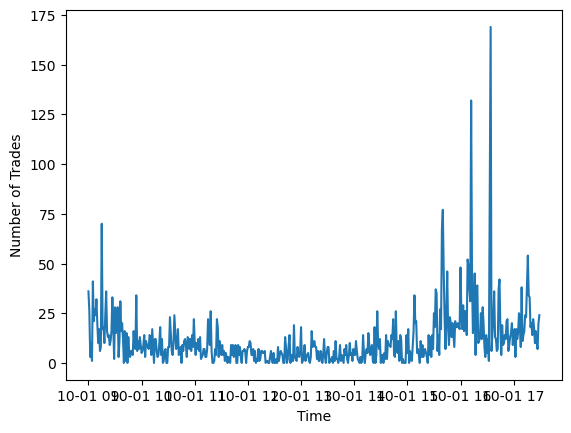

In [6]:
plt.plot(dg_1min.index, dg_1min['trade_count'])
plt.xlabel('Time')
plt.ylabel('Number of Trades')

# close price series

In [9]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Sanofi on Euronext Paris
symbol = "SAN.PA"

# Create a Ticker object
sanofi_ticker = yf.Ticker(symbol)

# Fetch the complete history available for the ticker
# 'period="max"' gets all available data. 'interval="1d"' ensures daily data.
print(f"Fetching daily history for {symbol}...")
hist_df = sanofi_ticker.history(period="max", interval="1d")

if hist_df.empty:
    print("Failed to fetch data. The ticker might be incorrect or there's a connection issue.")
else:
    # The index is already a DatetimeIndex. We can reset it to make 'Date' a column.
    hist_df = hist_df.reset_index()
    
    # Optional: Keep only the relevant columns and ensure 'Date' is just the date part
    hist_df['Date'] = pd.to_datetime(hist_df['Date']).dt.date
    
    # Define the output filename
    out_csv = f"sanofi_{symbol}_yahoo_daily.csv"
    
    # Save to CSV
    hist_df.to_csv(out_csv, index=False)
    
    print(f"Successfully saved {len(hist_df)} rows of data to {out_csv}")
    print("Columns:", hist_df.columns.tolist())
    print("\nLast 5 rows of data:")
    print(hist_df.tail())


Fetching daily history for SAN.PA...
Successfully saved 6698 rows of data to sanofi_SAN.PA_yahoo_daily.csv
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

Last 5 rows of data:
            Date       Open       High        Low      Close   Volume  \
6693  2026-01-20  78.739998  79.019997  77.260002  78.029999  2245095   
6694  2026-01-21  78.559998  78.690002  77.839996  78.400002  2861388   
6695  2026-01-22  78.989998  79.760002  78.660004  79.760002  2177264   
6696  2026-01-23  78.900002  80.349998  78.500000  79.309998  1993851   
6697  2026-01-26  79.930000  80.000000  79.459999  79.879997  1428272   

      Dividends  Stock Splits  
6693        0.0           0.0  
6694        0.0           0.0  
6695        0.0           0.0  
6696        0.0           0.0  
6697        0.0           0.0  


In [11]:
df = pd.read_csv(r"C:\Users\Wentao\Desktop\EA_recherche\Hawkes\sanofi_SAN.PA_yahoo_daily.csv")

In [12]:
return_log = np.log(df['Close'] / df['Close'].shift(1))
print(return_log)

0            NaN
1      -0.064207
2      -0.043090
3       0.037771
4       0.051960
          ...   
6693   -0.012228
6694    0.004731
6695    0.017198
6696   -0.005658
6697    0.007161
Name: Close, Length: 6698, dtype: float64


In [20]:
hawks_extreme_returns = return_log[return_log > 0.02]
hawks_extreme_returns.describe()

count    546.000000
mean       0.031424
std        0.012298
min        0.020008
25%        0.023308
50%        0.027428
75%        0.035853
max        0.136811
Name: Close, dtype: float64

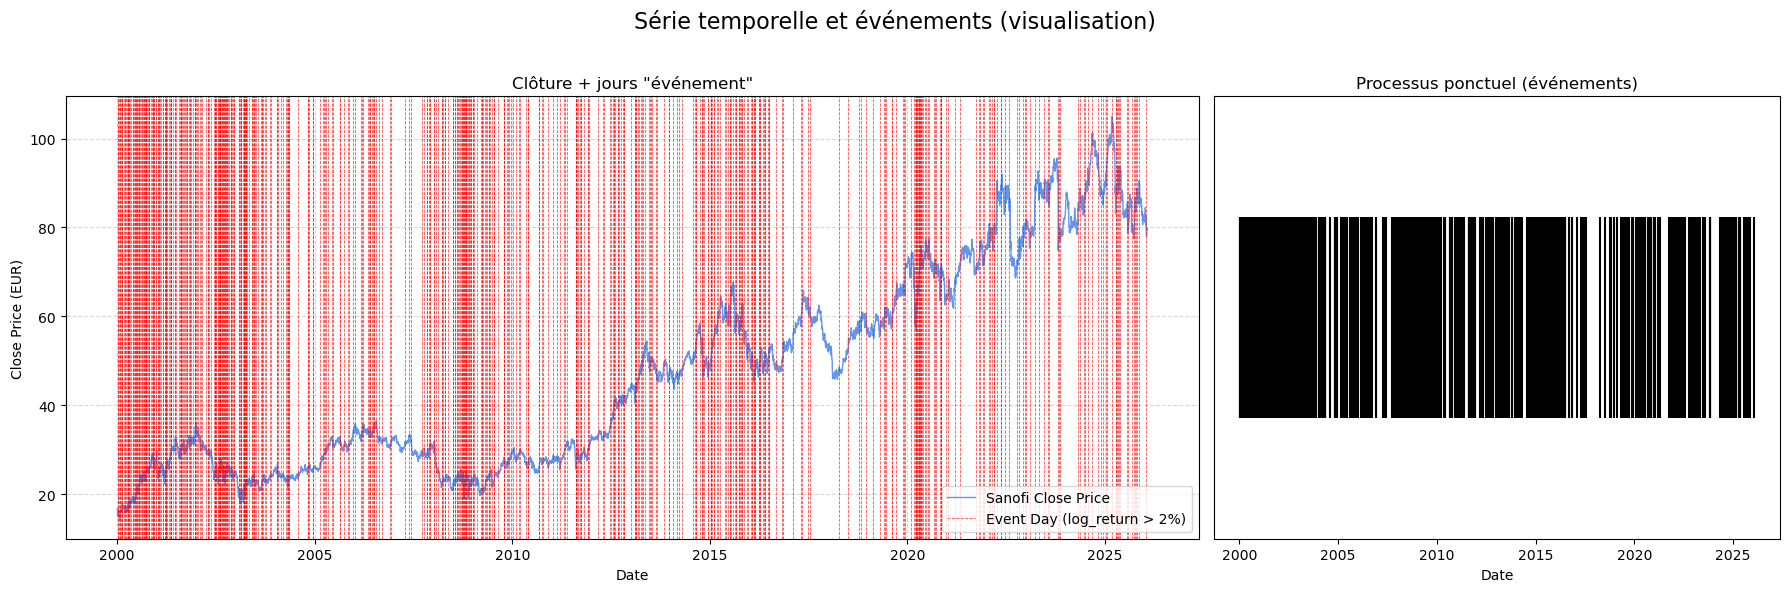

图表已保存为 sanofi_close_and_events_visualization.png


In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# --- 数据准备 ---
# 确保我们使用的是从CSV加载的最新数据框
# 并且'Date'列是datetime对象，以便正确绘图
df['Date'] = pd.to_datetime(df['Date'])

# 计算对数收益率
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

# 识别发生极端收益的“事件”
# 我们将事件定义为对数收益率大于2%
event_threshold = 0.02
df['is_event'] = df['log_return'] > event_threshold

# 获取所有事件发生的日期
event_dates = df.loc[df['is_event'], 'Date']

# --- 绘图 ---
# 创建一个包含两个子图的图表
fig, (ax1, ax2) = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(18, 6), 
    gridspec_kw={'width_ratios': [2, 1]} # 让左图更宽
)
fig.suptitle('Série temporelle et événements (visualisation)', fontsize=16)

# --- 子图1: 收盘价 + 事件日 ---
ax1.plot(df['Date'], df['Close'], label='Sanofi Close Price', color='cornflowerblue', linewidth=1)

# 在事件日绘制垂直线
for event_date in event_dates:
    ax1.axvline(x=event_date, color='red', linestyle='--', linewidth=0.6, alpha=0.7)

ax1.set_title('Clôture + jours "événement"')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price (EUR)')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.legend(['Sanofi Close Price', 'Event Day (log_return > 2%)'])

# 优化日期显示
ax1.xaxis.set_major_locator(mdates.YearLocator(5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


# --- 子图2: 事件的点过程 ---
# eventplot非常适合绘制这种时间点图
ax2.eventplot(event_dates, orientation='horizontal', colors='black', linelengths=0.8)

ax2.set_title('Processus ponctuel (événements)')
ax2.set_yticks([]) # 隐藏y轴刻度，因为它没有意义
ax2.set_xlabel('Date')

# 优化日期显示，使其与左图对齐
ax2.set_xlim(ax1.get_xlim()) # 确保两个图的x轴范围相同
ax2.xaxis.set_major_locator(mdates.YearLocator(5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


# 调整布局并显示图表
plt.tight_layout(rect=[0, 0, 1, 0.96]) # 为总标题留出空间
plt.show()

# 保存图片（可选）
fig.savefig("sanofi_close_and_events_visualization.png")
print("图表已保存为 sanofi_close_and_events_visualization.png")